In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# cd
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Image-Blending-using-GP-GANs/src/")

In [0]:
# # In case you need the data
# !wget https://www.cse.iitb.ac.in/~charith/aligned_images.tar
# !mkdir data
# !mv aligned_images.tar data/aligned_images.tar
# os.chdir("data/")
# !tar -xf aligned_images.tar
# os.chdir("../")

In [0]:
# Importing
import random
import cv2
import time
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt

dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Reading Data


data = torch.load('../data/train.bin')
val_data = torch.load('../data/validation.bin')
def readBatch(batch_size, data):
  """ 
  It returns two tensors 
  First one consisting of composited images and Second original image
  Size of each tensor = batch_size X 3 X 64 X 64
  """
  folders = random.choices(list(range(len(data))), k=batch_size)
  composite = []
  original = []
  for folder_idx in folders:
    a, b = random.sample(list(range(len(data[folder_idx]))), 2)
    image_a = data[folder_idx][a]
    image_b = data[folder_idx][b]
    height , width = image_a.shape[:2]
    a, b = 16,16#random.sample(list(range(32)), 2)
    composited_image = np.array(image_a)
    composited_image[:,a:a+32, b:b+32] = image_b[:,a:a+32, b:b+32]
    composite.append(composited_image)
    original.append(image_a)
  composited = torch.tensor(composite, dtype=dtype, device=device)
  original_data = torch.tensor(original, dtype=dtype, device=device)
  return composited,original_data
  

In [0]:
# Blending GAN


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        # Encoder
        self.batch_norm = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 4000, 4)
        
        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        # Staring Decoder
        self.dconv5 = nn.ConvTranspose2d(4000, 512, 4)
        self.dconv4 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.dconv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.dconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.dconv1 = nn.ConvTranspose2d(64, 3, 4, 2, 1)
        
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.xavier_normal_(self.conv3.weight)
        torch.nn.init.xavier_normal_(self.conv4.weight)
        torch.nn.init.xavier_normal_(self.conv5.weight)
        
        torch.nn.init.xavier_normal_(self.dconv1.weight)
        torch.nn.init.xavier_normal_(self.dconv2.weight)
        torch.nn.init.xavier_normal_(self.dconv3.weight)
        torch.nn.init.xavier_normal_(self.dconv4.weight)
        torch.nn.init.xavier_normal_(self.dconv5.weight)
        
        

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2)) 
        x4 = F.relu(self.conv4(x3))
        x5 = F.relu(self.conv5(x4))
        x6 = F.relu(self.dconv5(x5))
        x7 = F.relu(self.dconv4(x6))
        x8 = F.relu(self.dconv3(x7))
        x9 = F.relu(self.dconv2(x8))
        x10 = F.relu(self.dconv1(x9))
        return x10

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to(dtype=dtype, device=device)
print(net)

In [0]:

# training loop

net = Net()
weights_file = 'networks/network_7'
# net.load_state_dict(torch.load('networks/network_7'))
net.to(dtype=dtype, device=device)

epochs = 5
batch_size = 16
lr = 1e-5
alpha, beta = 0.9,0.99
regulirizer = 0.00001 
optimizer = optim.SGD(net.parameters(), lr=lr)#, betas = (alpha,beta))
num_batches = 512


f= open(weights_file+".txt","w+")
f.write("lr : "+str(lr))
f.write("\nbatch_size : "+str(batch_size))
f.write("\nalpha : "+str(alpha))
f.write("\nbeta : "+str(beta))
f.write("\nnum_batches : "+str(num_batches))
# training loop
for epoch in range(epochs):
  t=time.time()
  for i in range(num_batches):
    input, target = readBatch(batch_size,data)
    optimizer.zero_grad()
    output = net(input)
    criterion = nn.MSELoss()
    l2_reg = 0
    for param in net.parameters():
      l2_reg += torch.norm(param)
    loss = criterion(output, target) +  regulirizer * l2_reg
    if (i)%128==0:
      t = time.time()-t
      print(epoch,i,loss)
      f.write("\nepoch "+str(epoch))
      f.write("\n"+str(loss))
      f.write("\ntime elapsed:"+str(t))
      print("time elapsed:",t)
      t = time.time()
    loss.backward()     # Does Backpropogation
    optimizer.step()    # Does the update
  if((epoch+1)%1==0):
      for pp in optimizer.param_groups:
        pp['lr'] /= 4
  torch.save(net.state_dict(), weights_file)
    
print(list((net.parameters()))[-2])
f.close()
torch.save(net.state_dict(), weights_file)

In [0]:
import torchvision
import matplotlib.pyplot as plt
[input, target] = readBatch(1,val_data)

output = net(input)
# output = input
output=output.permute(0,2,3,1)
input=input.permute(0,2,3,1)

target=target.permute(0,2,3,1)
input1 = (np.asarray(input.cpu()))
output1 = np.asarray(output.detach().cpu())
target1 = np.asarray(target.cpu())
# print(input.size())
cv2.imwrite('composite.jpg',input1[0]*255)
cv2.imwrite('result.jpg',output1[0]*255)
cv2.imwrite('target.jpg',target1[0]*255)
# plt.imshow(input1[0])
# display(Image(input1[0]))
plt.figure()
plt.imshow(input1[0])
plt.figure()
plt.imshow(output1[0])
plt.figure()
plt.imshow(target1[0])

# print(output1)

In [0]:
#Used to create downsampled data
  
def savedata_new(dir):
  """ 
  It returns two tensors 
  First one consisting of composited images and Second original image
  Size of each tensor = batch_size X 3 X 64 X 64
  """

  os.chdir("../data/"+dir+"/")
  folders = next(os.walk('.'))[1]
  data = []
  for folder in folders:
    print(folder)
    os.chdir(folder)
    l = next(os.walk('.'))[2]
    scene_list=[]
    for t in range(len(l)) :
    
      img = cv2.cvtColor(cv2.imread(l[t]), cv2.COLOR_BGR2RGB)
      img = img/255.0    

      height , width = img.shape[:2]
      steps = 8
      
      t = int(max(2**math.ceil(math.log(height,2)),2**math.ceil(math.log(width,2))))
      img = cv2.resize(img, (t, t), interpolation=cv2.INTER_NEAREST)
      
      
      while(t!=64):
        t=int(t//2)
        img = cv2.pyrDown(img)a
      img = np.moveaxis(img, -1, 0)
      scene_list.append(img)
    data.append(scene_list)
    os.chdir('..')
  os.chdir("../../src/")
#   data = torch.tensor(data, dtype=dtype, device=device)
  torch.save(data,"../data/"+dir+".bin")

os.chdir("/content/drive/My Drive/Colab Notebooks/Image-Blending-using-GP-GANs/src/")
savedata_new("test")
savedata_new("validation")
savedata_new("train")

In [0]:
# os.chdir("/content/drive/My Drive/Colab Notebooks/Image-Blending-using-GP-GANs/src/")
# savedata("test")
# savedata("validation")
# savedata("train")

In [0]:
model = Net()
model.load_state_dict(torch.load('networks/network_weights_5'))
model.to(dtype=dtype, device=device)
net = model

In [0]:

[input, target] = readBatch(1,data)

output = model(input)
output=output.permute(0,2,3,1)
input=input.permute(0,2,3,1)

target=target.permute(0,2,3,1)
input1 = (np.asarray(input.cpu()))
output1 = np.asarray(output.detach().cpu())
target1 = np.asarray(target.cpu())
# print(input.size())
cv2.imwrite('composite.jpg',input1[0]*255)
cv2.imwrite('result.jpg',output1[0]*255)
cv2.imwrite('target.jpg',target1[0]*255)
# plt.imshow(input1[0])
# display(Image(input1[0]))
plt.figure()
plt.imshow(input1[0])
plt.grid(b=None)
plt.figure()
plt.imshow(output1[0])
plt.grid(b=None)
plt.figure()
plt.imshow(target1[0])
plt.grid(b=None)
# print(output1)

In [0]:
def getGaussian(img):
  Gaussian = torch.tensor([[[[1,2,1],[2,4,2],[1,2,1]]]],device=device,dtype=dtype)
  img_b = torch.stack([torch.nn.functional.conv2d(img[:,:,0].unsqueeze(0).unsqueeze(0), Gaussian,stride=1, padding=1)[0,0]
               ,torch.nn.functional.conv2d(img[:,:,1].unsqueeze(0).unsqueeze(0), Gaussian,stride=1, padding=1)[0,0]
               ,torch.nn.functional.conv2d(img[:,:,2].unsqueeze(0).unsqueeze(0), Gaussian,stride=1, padding=1)[0,0]]).permute(1,2,0)
  return img_b
  
def getLaplacian(img):
  Laplacian = torch.tensor([[[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]]],device=device,dtype=dtype)
  img_blurr = img
  return torch.stack([torch.nn.functional.conv2d(img_blurr[:,:,0].unsqueeze(0).unsqueeze(0), Laplacian,stride=1, padding=1)[0,0]
               ,torch.nn.functional.conv2d(img_blurr[:,:,1].unsqueeze(0).unsqueeze(0), Laplacian,stride=1, padding=1)[0,0]
               ,torch.nn.functional.conv2d(img_blurr[:,:,2].unsqueeze(0).unsqueeze(0), Laplacian,stride=1, padding=1)[0,0]]).permute(1,2,0)

In [0]:

# optimizing GP equation using Gradient Descent

def solveGP(Lsrc, Ldest, mask, xl):
  """
  Solving the GP equation and returns approximate solution using Gradient Descent
  src, dest and mask are torch tensors
  Lsrc.size() = [3, l, b]
  Ldest.size() = [3, l, b]
  mask.size() = [l, b]
  """ 
  
#   print(Lsrc.size(),xl.size())
  Lsrc = Lsrc.clone().detach()
  Ldest = Ldest.clone().detach()
  mask = mask.clone().detach()
  Lcomp = Lsrc
  Lcomp[mask==1] = Ldest[mask==1]
  Lcomp = Lcomp.detach().clone()
  xl = xl.clone().detach()
#   xh = xl
  xh = xl.clone().detach().requires_grad_(True)

  
  optimizer = torch.optim.SGD([xh], lr=0.1)

  c = nn.MSELoss()
  
#   print(xh-xl)
#   print(Lcomp-getLaplacian(xh))
  
  for i in range(10000):
    if((i+1)%1000==0):
      optimizer.param_groups[0]['lr'] /= 2.5
      print(loss)
    loss = c(getGaussian(xh), xl) + c(Lcomp, getLaplacian(xh))     # GP-loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(loss)
  return xh


In [0]:
# Using pyramid blending approach to obtain approximate solution GP equation

def pyramidBlending(src,dest,mask,net):
  
  height,width,_ = src.size()
  
  h = int(max(2**math.ceil(math.log(height,2)),2**math.ceil(math.log(width,2))))
  w = h
  
  src1 = src.cpu().numpy()
  dest1 = dest.cpu().numpy()
  mask1 = mask.cpu().numpy()
  
  src1 = cv2.resize(src1, (w, h), interpolation=cv2.INTER_LINEAR)
  dest1 = cv2.resize(dest1, (w, h), interpolation=cv2.INTER_LINEAR)
  mask1 = cv2.resize(mask1, (w, h), interpolation=cv2.INTER_NEAREST)
  
  
  comp = src1
  comp[mask1==1] = dest1[mask1==1]
  
  src_G =[]
  dest_G = []
  mask_G = []
  
  t = h
  while(t!=32):
    print(t)
    t=int(t//2)
    
    src_G.append(src1)
    dest_G.append(dest1)
    mask_G.append(mask1)
    
    src1 = cv2.pyrDown(src1)
    dest1 = cv2.pyrDown(dest1)
    mask1 = cv2.resize(mask1, (t, t), interpolation=cv2.INTER_NEAREST)
    
    
    
  comp_I = src_G[-1]
  comp_I[mask_G[-1]==1] = dest_G[-1][mask_G[-1]==1]
  comp_L = []
  
  for i in reversed(list(range(len(src_G)-1))):
    t=t*2
    src_l = cv2.subtract(src_G[i], cv2.pyrUp(src_G[i+1]))
    dest_l =  cv2.subtract(dest_G[i], cv2.pyrUp(dest_G[i+1]))
    
    comp_l = src_l
    comp_l[mask_G==1] = dest_l[mask_G==1]
    
    comp_L.append(comp_l)
  
  comp_I = comp_I/255
  

  plt.imshow(comp_I)
  plt.figure()
  xl = net(torch.tensor(comp_I,dtype=dtype,device=device).permute(2,0,1).unsqueeze(0))[0].permute(1,2,0).cpu().detach().numpy()
  print(xl.shape)
  plt.imshow(xl)
  plt.figure()
  xl = xl*255
#   xl = comp_I*255
  
  xh = xl
  for i in range(0,len(comp_L)):
    
    xl = cv2.pyrUp(xh)
    xh = cv2.add(xl,comp_L[i])
    
    
  xh = cv2.resize(xh, (width, height), interpolation=cv2.INTER_LINEAR)
  
  return xh,comp
  


In [0]:
# Blending image using SGD

def blendImageSGD(src,dest,mask,net):
  
  height,width,_ = src.size()
  
  h = int(max(2**math.ceil(math.log(height,2)),2**math.ceil(math.log(width,2))))
  w = h
  
  src1 = src.cpu().numpy()
  dest1 = dest.cpu().numpy()
  mask1 = mask.cpu().numpy()
  
  src1 = cv2.resize(src1, (w, h), interpolation=cv2.INTER_LINEAR)
  dest1 = cv2.resize(dest1, (w, h), interpolation=cv2.INTER_LINEAR)
  mask1 = cv2.resize(mask1, (w, h), interpolation=cv2.INTER_NEAREST)
  
  
  comp = src1
  comp[mask1==1] = dest1[mask1==1]
  
  src_G =[]
  dest_G = []
  mask_G = []
  
  t = h
  while(t!=32):
    t=int(t//2)
    
    src_G.append(src1)
    dest_G.append(dest1)
    mask_G.append(mask1)
    
    src1 = cv2.pyrDown(src1)
    dest1 = cv2.pyrDown(dest1)
    mask1 = cv2.resize(mask1, (t, t), interpolation=cv2.INTER_NEAREST)
    
  src_G.append(src1)
  dest_G.append(dest1)
  mask_G.append(mask1)
    
  comp_I = src_G[-2]
  comp_I[mask_G[-2]==1] = dest_G[-2][mask_G[-2]==1]
  comp_L = []
  src_L = []
  dest_L = []
  
  for i in reversed(list(range(len(src_G)-1))):
    t=t*2
    src_l = cv2.subtract(src_G[i], cv2.pyrUp(src_G[i+1]))
    dest_l =  cv2.subtract(dest_G[i], cv2.pyrUp(dest_G[i+1]))
    
    comp_l = src_l
    comp_l[mask_G==1] = dest_l[mask_G==1]
    
    src_L.append(src_l)
    dest_L.append(dest_l)
    comp_L.append(comp_l)
  
  comp_I = comp_I/255
  

  print(torch.tensor(comp_I,dtype=dtype,device=device).permute(2,0,1).unsqueeze(0).size())
  xl = net(torch.tensor(comp_I,dtype=dtype,device=device).permute(2,0,1).unsqueeze(0))[0].permute(1,2,0).cpu().detach().numpy()
  xl = xl*255

  
  for i in range(0,len(comp_L)-1):
    print(i)
    xh = solveGP(torch.tensor(src_L[i],device=device,dtype=dtype),
                 torch.tensor(dest_L[i],device=device,dtype=dtype),
                 torch.tensor(mask_G[-i-2],device=device,dtype=dtype),
                 torch.tensor(xl,device=device,dtype=dtype))
    xl = cv2.pyrUp(xh.cpu().detach().numpy())

  xh = solveGP(torch.tensor(src_L[-1],device=device,dtype=dtype),
               torch.tensor(dest_L[-1],device=device,dtype=dtype),
               torch.tensor(mask_G[0],device=device,dtype=dtype),
               torch.tensor(xl,device=device,dtype=dtype))
    
  xh = cv2.resize(xh.cpu().detach().numpy(), (width, height), interpolation=cv2.INTER_LINEAR)
  
  return xh,comp
  


torch.Size([480, 640, 3])
1024
512
256
128
64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


Text(0.5, 1.0, 'res')

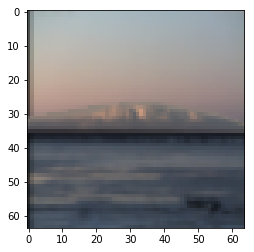

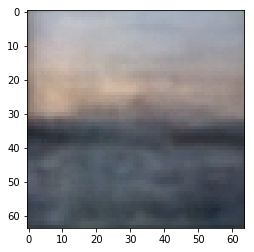

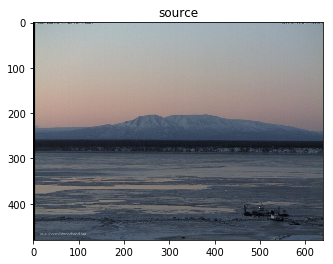

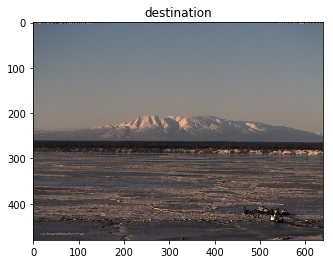

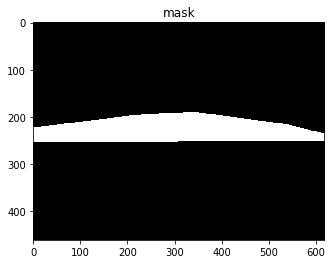

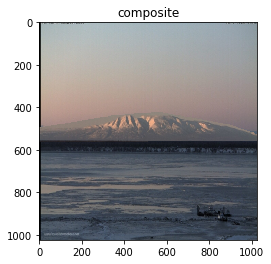

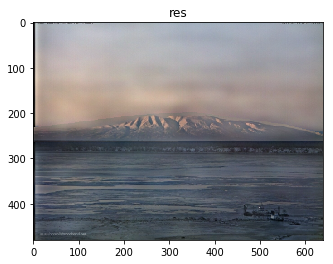

In [40]:
src = torch.tensor(cv2.cvtColor(cv2.imread('../data/test/00001065/20110114_012716.jpg'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device)
dest = torch.tensor(cv2.cvtColor(cv2.imread('../data/test/00001065/20110115_225619.jpg'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device) 
mask = torch.tensor(cv2.cvtColor(cv2.imread('../data/cropped_masks/00001065/mountain_1.png'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device)


# mask = torch.zeros(dest.size()[0],dest.size()[1],dtype=dtype,device=device)
# mask[300:400,200:400] = 1
print(src.size())
res,comp = pyramidBlending(src,dest,mask,net)
# print(compositeImg.size())
plt.imshow(src.cpu()/255)
plt.title('source')
plt.figure()

plt.imshow(dest.cpu()/255)
plt.title('destination')
plt.figure()

plt.imshow(mask.cpu())
plt.title('mask')
plt.figure()
plt.imshow(comp/255)
plt.title('composite')
plt.figure()
plt.imshow(res/255)
plt.title('res')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([480, 640, 3])
1024
512
256
128
64
(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'res')

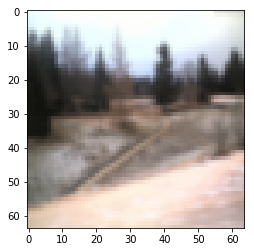

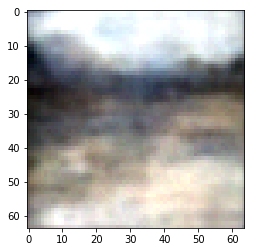

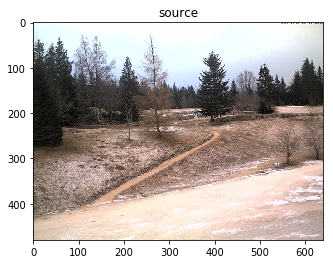

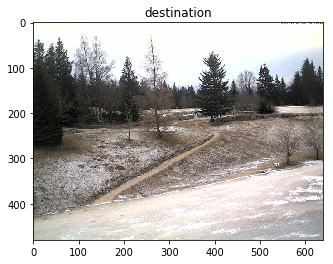

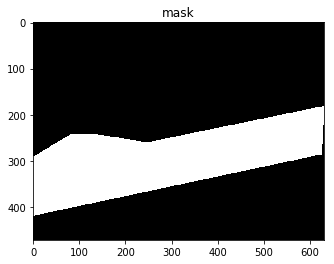

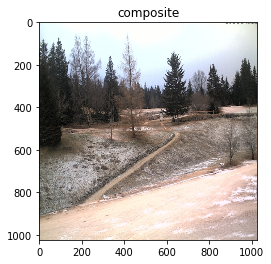

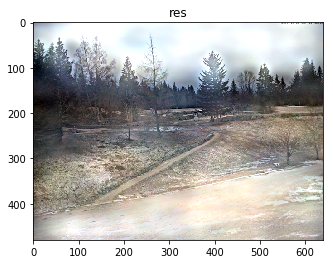

In [9]:
src = torch.tensor(cv2.cvtColor(cv2.imread('../data/test/00008346/20110122_074558.jpg'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device)
dest = torch.tensor(cv2.cvtColor(cv2.imread('../data/test/00008346/20110122_091558.jpg'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device) 
mask = torch.tensor(cv2.cvtColor(cv2.imread('../data/cropped_masks/00008346/grass_2.png'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device)


# mask = torch.zeros(dest.size()[0],dest.size()[1],dtype=dtype,device=device)
# mask[300:400,200:400] = 1
print(src.size())
res,comp = pyramidBlending(src,dest,mask,net)
# print(compositeImg.size())
plt.imshow(src.cpu()/255)
plt.title('source')
plt.figure()

plt.imshow(dest.cpu()/255)
plt.title('destination')
plt.figure()

plt.imshow(mask.cpu())
plt.title('mask')
plt.figure()
plt.imshow(comp/255)
plt.title('composite')
plt.figure()
plt.imshow(res/255)
plt.title('res')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([480, 640, 3])


Text(0.5, 1.0, 'res')

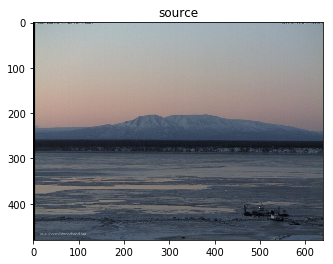

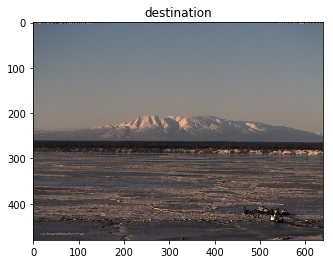

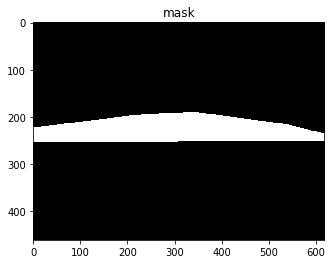

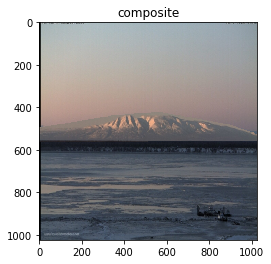

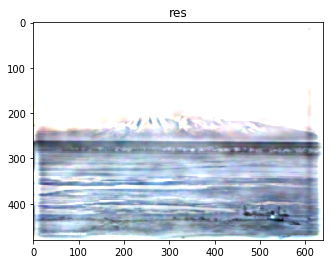

In [35]:
src = torch.tensor(cv2.cvtColor(cv2.imread('../data/test/00001065/20110114_012716.jpg'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device)
dest = torch.tensor(cv2.cvtColor(cv2.imread('../data/test/00001065/20110115_225619.jpg'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device) 
mask = torch.tensor(cv2.cvtColor(cv2.imread('../data/cropped_masks/00001065/mountain_1.png'), cv2.COLOR_BGR2RGB),dtype=dtype,device=device)


# mask = torch.zeros(dest.size()[0],dest.size()[1],dtype=dtype,device=device)
# mask[300:400,200:400] = 1
print(src.size())
# res,comp = blendImageSGD(src,dest,mask,net)
# print(compositeImg.size())
plt.imshow(src.cpu()/255)
plt.title('source')
plt.figure()

plt.imshow(dest.cpu()/255)
plt.title('destination')
plt.figure()

plt.imshow(mask.cpu())
plt.title('mask')
plt.figure()
plt.imshow(comp/255)
plt.title('composite')
plt.figure()
plt.imshow(res)
plt.title('res')
# print(res/(np.max(res)))
